<a href="https://colab.research.google.com/github/Altemir1/Crypto-DL-Based-Trading-System/blob/main/LSTM_price_predicton_with_technical_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

df = pd.read_csv("eth_ti_1d.csv")

df.head()

,date,date.1,open,high,low,close,volume,volume_usd,ema_5,ema_20,...,kc_lower,donchian_upper,donchian_lower,donchian_middle,obv,vwap_num,vwap_denom,vwap,cmf,ad_line
0,2017-10-05,2017-10-05,290.00,297.44,285.53,294.81,3412.39016,1.006007e+06,295.022651,292.872474,...,263.742167,313.0,235.51,274.255,-25872.70630,8.192443e+07,272334.71430,300.822589,0.105217,25469.769973
1,2017-10-06,2017-10-06,294.78,310.80,293.78,310.80,3541.02359,1.100550e+06,300.281767,294.579858,...,267.352000,313.0,239.02,276.010,-22331.68271,8.302498e+07,275875.73789,300.950654,0.183252,29010.793563
2,2017-10-07,2017-10-07,309.90,318.50,303.60,311.01,2165.79076,6.735826e+05,303.857845,296.144633,...,270.744667,318.5,252.10,285.300,-20165.89195,8.369857e+07,278041.52865,301.029011,0.163131,28999.165156
3,2017-10-08,2017-10-08,311.08,317.07,309.00,311.07,2960.93198,9.210571e+05,306.261897,297.566097,...,274.117333,318.5,252.10,285.300,-17204.95997,8.461962e+07,281002.46063,301.134813,0.121816,27557.224304
4,2017-10-09,2017-10-09,311.13,312.13,286.65,297.19,4885.37863,1.451886e+06,303.237931,297.530278,...,274.548833,318.5,252.10,285.300,-22090.33860,8.607151e+07,285887.83926,301.067403,0.116781,26713.595341


In [4]:
df.drop(columns=["date.1", ], inplace=True)

Select necessary features

In [5]:
df_selected = df.drop(columns=["open",
                               "high",
                               "low",
                               "volume",
                               "vwap_num",
                               "vwap_denom",
                               ])


### Transformations before fitting

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_price_data(df):
    df = df.copy()

    # Log-transform volume and price
    df['log_volume'] = np.log1p(df['volume_usd'])
    df['log_close'] = np.log1p(df['close'])
    df.drop(columns=['volume_usd', 'close'], inplace=True)

    # Normalize continuous unbounded features
    features_to_normalize = [
        'ema_5', 'ema_20', 'ema_50',
        'macd', 'histogram',
        'adx', 'plus_di', 'minus_di',
        'psar', 'psar_up', 'psar_down',
        'momentum', 'cci',
        'bb_upper', 'bb_lower',
        'donchian_upper', 'donchian_lower', 'donchian_middle',
        'obv', 'ad_line', 'cmf', "signal", "%K", "bb_middle", "atr","kc_upper",
        "kc_middle", "kc_lower","vwap"
    ]


    scaler = MinMaxScaler()
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

    return df


df_selected = preprocess_price_data(df_selected)

# Make a classification task instead of regression for 1 day shift
df_selected['future_return'] = df_selected['log_close'].shift(-1) - df_selected['log_close']
df_selected['target'] = (df_selected['future_return'] > 0).astype(int)  # 1 = price up, 0 = price down
df_selected.drop("future_return", axis=1, inplace=True)
# Add time based features
df_selected["date"] = pd.to_datetime(df_selected["date"])
df_selected['day_of_week'] = df_selected['date'].dt.dayofweek
df_selected['month'] = df_selected['date'].dt.month
df_selected.drop("date", axis=1, inplace=True)


df_selected.head()


,ema_5,ema_20,ema_50,macd,signal,histogram,adx,plus_di,minus_di,psar,...,donchian_middle,obv,vwap,cmf,ad_line,log_volume,log_close,target,day_of_week,month
0,0.045622,0.043768,0.043292,0.414870,0.419383,0.692676,0.426636,0.222829,0.517111,0.032932,...,0.039937,0.124974,0.057818,0.575642,0.000172,13.821500,5.689717,1,3,10
1,0.046768,0.044157,0.043416,0.416650,0.420414,0.694717,0.407605,0.293154,0.488590,0.033547,...,0.040339,0.125021,0.057918,0.676949,0.000199,13.911322,5.742362,1,4,10
2,0.047548,0.044514,0.043538,0.418047,0.421558,0.695637,0.381432,0.326691,0.464236,0.034138,...,0.042467,0.125050,0.057979,0.650827,0.000199,13.420367,5.743035,1,5,10
3,0.048072,0.044838,0.043654,0.419114,0.422716,0.695757,0.357129,0.315849,0.451033,0.035057,...,0.042467,0.125089,0.058061,0.597191,0.000188,13.733278,5.743228,0,6,10
4,0.047413,0.044829,0.043634,0.418481,0.423498,0.692686,0.352575,0.282859,0.558180,0.035921,...,0.042467,0.125024,0.058008,0.590654,0.000182,14.188374,5.697731,1,0,10


In [7]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2681 entries, 0 to 2680
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ema_5            2681 non-null   float64
 1   ema_20           2681 non-null   float64
 2   ema_50           2681 non-null   float64
 3   macd             2681 non-null   float64
 4   signal           2681 non-null   float64
 5   histogram        2681 non-null   float64
 6   adx              2681 non-null   float64
 7   plus_di          2681 non-null   float64
 8   minus_di         2681 non-null   float64
 9   psar             2681 non-null   float64
 10  psar_down        2681 non-null   float64
 11  psar_up          2681 non-null   float64
 12  rsi              2681 non-null   float64
 13  %K               2681 non-null   float64
 14  %D               2681 non-null   float64
 15  cci              2681 non-null   float64
 16  momentum         2681 non-null   float64
 17  bb_upper      

### Splitting dataset

In [8]:
target_column = 'target'  # Our prediction target
feature_columns = [col for col in df_selected.columns if col != target_column]

X_raw = df_selected[feature_columns].values  # Features (OHLC, indicators, volume, etc.)
y_raw = df_selected[target_column].values  # Target (log close price)

In [9]:
X_raw.shape

(2681, 35)

Creating sequence of features according to the windwo size

In [10]:
import numpy as np

def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - 1):
        X_seq.append(X[i:i+window_size])  # Select past `window_size` observations
        y_seq.append(y[i+window_size])  # Target is the next Close price
    return np.array(X_seq), np.array(y_seq)

### Model creation and training loop

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,           # Stop if no improvement for 15 epochs
    restore_best_weights=True  # Revert to the best model
)

def build_lstm_model(window_size, num_features):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(window_size, num_features)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation="sigmoid")  # Predicting direction
    ])

    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
    return model

Ordinary training loop

In [14]:
# Define different window sizes
window_sizes = [10, 20, 30, 40, 50, 60, 70]

# Store results
models = {}
history_results = {}
x_tests = {}
y_tests = {}


for window_size in window_sizes:
    print(f"Training LSTM with window size: {window_size}")

    # Create sequences for the current window size
    X, y = create_sequences(X_raw, y_raw, window_size)


    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]


    x_tests[window_size] = X_test
    y_tests[window_size] = y_test

    # Build and train model with automatic validation split
    model = build_lstm_model(window_size, X.shape[2])
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=64,
                        validation_split=0.1,
                        callbacks=[early_stop])  # 10% of training data used as validation

    # Store trained model and history
    models[window_size] = model
    history_results[window_size] = history

Training LSTM with window size: 10
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4765 - loss: 0.6959 - val_accuracy: 0.4579 - val_loss: 0.7008
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4972 - loss: 0.6938 - val_accuracy: 0.4579 - val_loss: 0.6948
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5088 - loss: 0.6922 - val_accuracy: 0.4579 - val_loss: 0.6971
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5170 - loss: 0.6921 - val_accuracy: 0.5421 - val_loss: 0.6910
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5363 - loss: 0.6927 - val_accuracy: 0.4579 - val_loss: 0.7071
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4882 - loss: 0.6966 - val_accuracy: 0.4579 - val_loss: 0.6976
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5058 - loss: 0.6950 - val_accuracy: 0.4579 - val_loss: 0.6938
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5412 - loss

KeyboardInterrupt: 

Training loop utilizing Adaboosting

In [16]:
import numpy as np

# Parameters
window_sizes = [10, 20, 30, 40, 50, 60, 70]
num_boosting_rounds = 5

# Store results
boosted_models = {}         # {window_size: [(model1, alpha1), (model2, alpha2), ...]}
x_tests = {}
y_tests = {}

for window_size in window_sizes:
    print(f"\n🔁 Training AdaBoosted LSTM with window size: {window_size}")

    # Step 1: Create sequences
    X, y = create_sequences(X_raw, y_raw, window_size)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    x_tests[window_size] = X_test
    y_tests[window_size] = y_test

    # Initialize sample weights equally
    sample_weights = np.ones(len(y_train)) / len(y_train)

    models_with_alphas = []

    for round_idx in range(num_boosting_rounds):
        print(f"  ➤ Round {round_idx + 1}/{num_boosting_rounds}")

        # Step 2: Build and train model on weighted data
        model = build_lstm_model(window_size, X.shape[2])
        history = model.fit(X_train, y_train,
                            sample_weight=sample_weights,
                            epochs=30,
                            batch_size=64,
                            validation_split=0.1,
                            callbacks=[early_stop],
                            verbose=0)

        # Step 3: Make predictions on training data
        y_pred_probs = model.predict(X_train).flatten()
        y_pred_labels = (y_pred_probs >= 0.5).astype(int)

        # Step 4: Calculate weighted error
        incorrect = (y_pred_labels != y_train).astype(int)
        error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)

        if error > 0.5 or error == 0:
            print(f"  ⚠️ Skipping round due to error = {error:.4f}")
            continue

        # Step 5: Compute alpha
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
        models_with_alphas.append((model, alpha))

        # Step 6: Update sample weights
        sample_weights = sample_weights * np.exp(alpha * incorrect * 2)  # increase weight for misclassified
        sample_weights /= np.sum(sample_weights)  # normalize

    # Store ensemble
    boosted_models[window_size] = models_with_alphas


🔁 Training AdaBoosted LSTM with window size: 10
  ➤ Round 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
  ➤ Round 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
  ➤ Round 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
  ➤ Round 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
  ➤ Round 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

🔁 Training AdaBoosted LSTM with window size: 20
  ➤ Round 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ➤ Round 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ➤ Round 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
  ➤ Round 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
  ➤ Round 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ⚠️ Skipping round due to error = 0.5002

🔁 Training AdaBoosted LSTM with window size: 30
  ➤ Round 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ⚠️ Skipping round due to error = 0.5099
  ➤ Round 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ➤ Round 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ➤ Round 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  ➤ Round 5/5
67/67 ━━━━━━━

(<Sequential name=sequential_32, built=True>, np.float64(0.0334093712726984))

### Evaluation

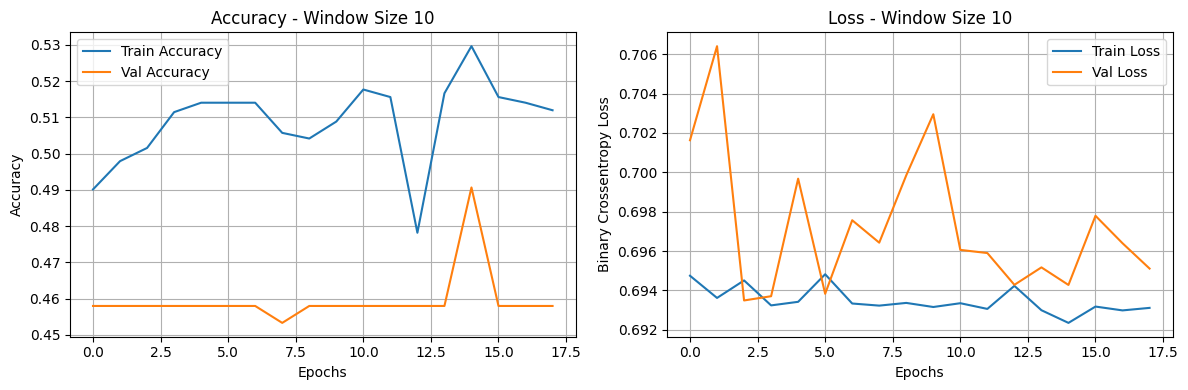

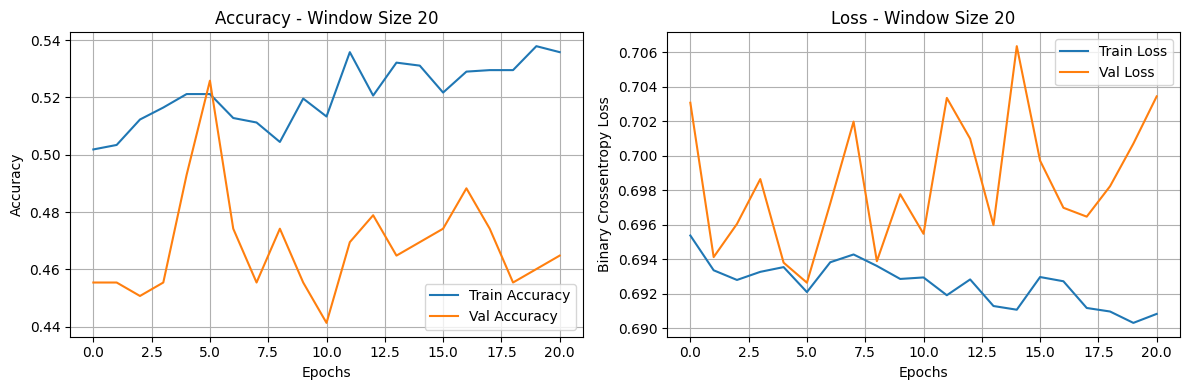

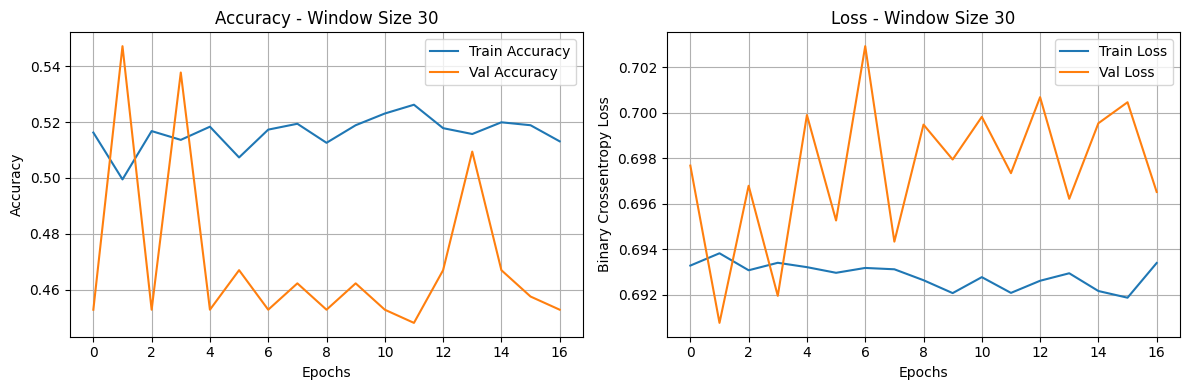

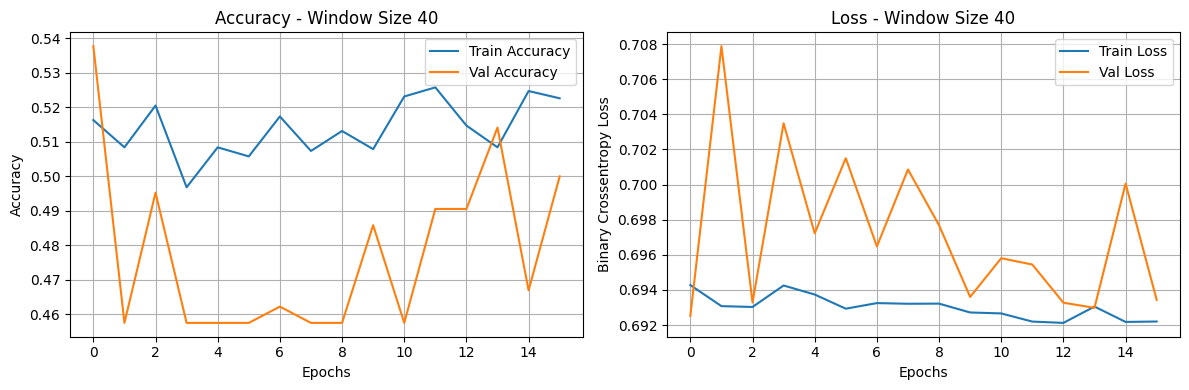

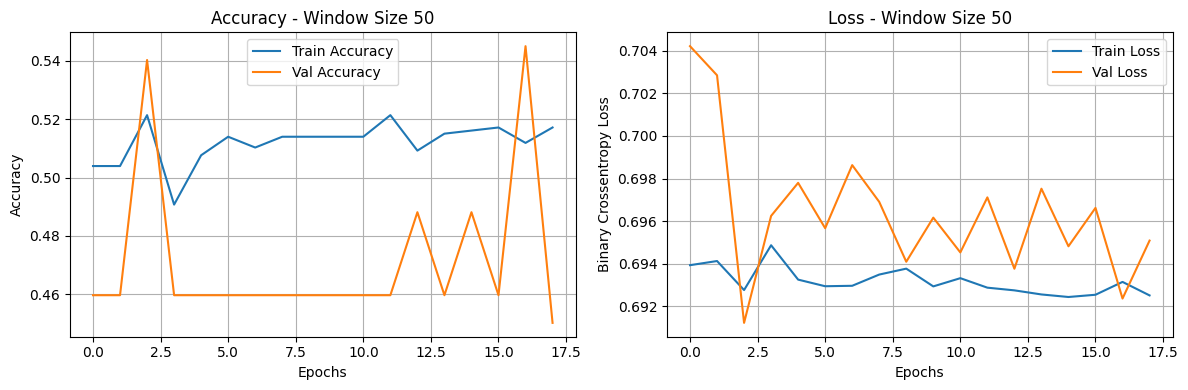

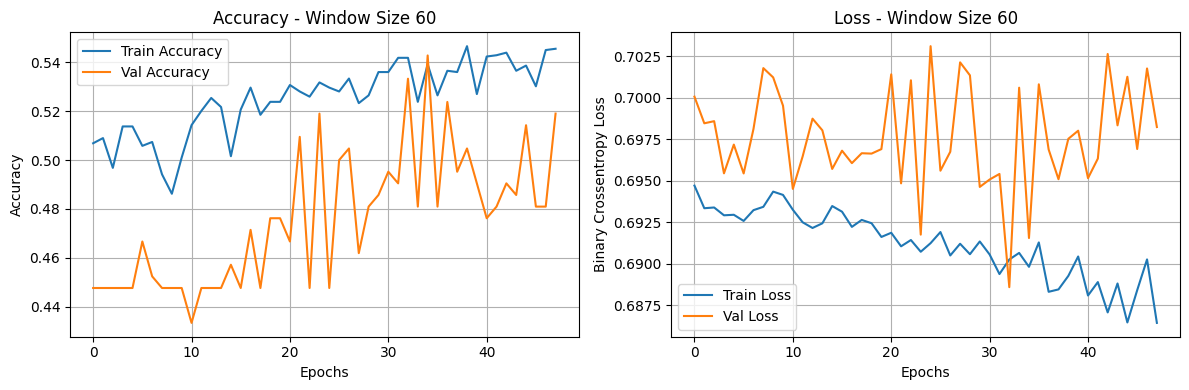

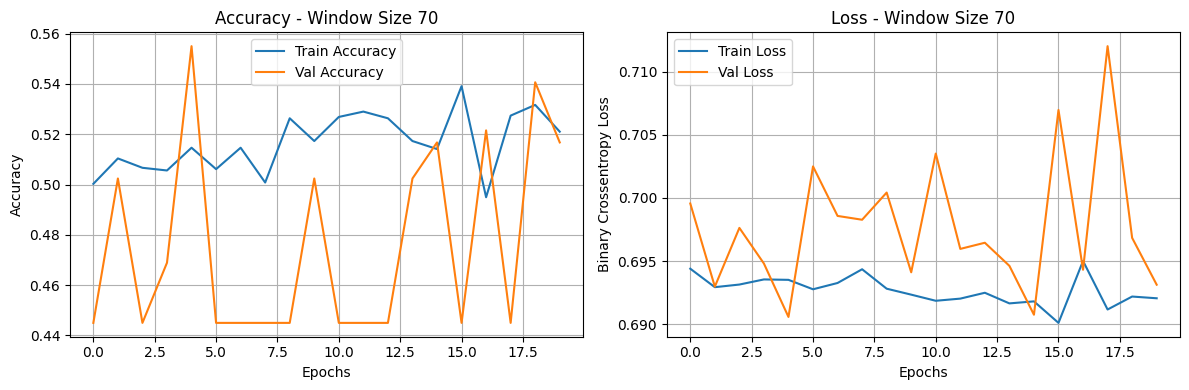

In [144]:
import matplotlib.pyplot as plt

# Loop through results
for window_size in history_results:
    history = history_results[window_size]

    # Plot Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy - Window Size {window_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Window Size {window_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [24]:
for window in window_sizes:
  x_test = x_tests[window]
  y_test = y_tests[window]

  for round in boosted_models[window]:
    model = round[0]
    y_pred = (model.predict(x_tests[window]) > 0.5).astype(int)



    accuracy = 0

    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            accuracy += 1

    accuracy = accuracy / len(y_test)
    print(f"Accuracy for window size {window}: {accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 10: 0.49063670411985016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 10: 0.4737827715355805
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 10: 0.5131086142322098
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy for window size 10: 0.5262172284644194
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy for window size 10: 0.4737827715355805
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 20: 0.4680451127819549
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for window size 20: 0.4718045112781955
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 20: 0.5093984962406015
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy for window size 20: 0.5263157894736842
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy for window size 30: 0.4849056603773585
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy for window size 30: 0.4849056603773585
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
A

### Permuation importance

In [132]:
# Create feature name list without target
feature_names = df_selected.columns
feature_names = list(feature_names)
feature_names.remove("target")

print("X_test shape:", X_test.shape)  # Should be (samples, time_steps, num_features)
print("Number of feature names:", len(feature_names))

X_test shape: (522, 70, 27)
Number of feature names: 27


In [133]:
for window_size in history_results:
    X_test = x_tests[window_size]
    y_test = y_tests[window_size]

    print(len(X_test), len(y_test))
    print(X_test.shape, y_test.shape)

534 534
(534, 10, 27) (534,)
532 532
(532, 20, 27) (532,)
530 530
(530, 30, 27) (530,)
528 528
(528, 40, 27) (528,)
526 526
(526, 50, 27) (526,)
524 524
(524, 60, 27) (524,)
522 522
(522, 70, 27) (522,)


In [134]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

for window_size in history_results:
    model = models[window_size]
    X_test = x_tests[window_size]
    y_test = y_tests[window_size]
    # Get baseline accuracy
    y_pred_base = (model.predict(X_test) > 0.5).astype(int)
    baseline_acc = accuracy_score(y_test, y_pred_base)

    # Initialize list to store drops in performance
    importances = []

    # Loop through each feature
    for i in range(X_test.shape[2]):
        X_temp = X_test.copy()

        # Shuffle this specific feature across all samples
        np.random.shuffle(X_temp[:, :, i])

        # Predict again with the shuffled data
        y_pred = (model.predict(X_temp) > 0.5).astype(int)

        # Measure new accuracy
        shuffled_acc = accuracy_score(y_test, y_pred)

        # Importance is how much the accuracy dropped
        drop = baseline_acc - shuffled_acc
        importances.append(drop)

    for i, importance in enumerate(importances):
        print(f"Feature {feature_names[i]}: Importance = {importance}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


### Testing strategy based on model

In [145]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.3 MB/s eta 0:00:00


In [193]:
import backtrader as bt

Creating dataset for backtrading

In [160]:
model= models[60]
X_test = x_tests[60]
y_pred_probs = model.predict(X_test).flatten()
len(y_pred_probs)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


524

In [164]:
# Get only the last timestep from each sequence
X_last = X_test[:, -1, :]  # shape: (samples, features)
feature_names = df_selected.columns
feature_names = list(feature_names)
feature_names.remove("target")

df_bt = pd.DataFrame(X_last, columns=feature_names)


In [166]:
df_bt["close"] = np.expm1(df_bt["log_close"])
df_bt = df_bt["close"]

In [187]:
df_origin = pd.read_csv("/content/ETHUSDT_1d_candlesticks.csv")

In [188]:
df_origin = df_origin.iloc[2204: 2204+len(df_bt)]
df_origin["close"] = df_bt.values
df_origin

<ipython-input-188-8d26a51a427a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_origin["close"] = df_bt.values


,Open Time,Open,High,Low,Close,Volume,close
2204,2023-08-30,1729.41,1730.93,1694.34,1705.23,2.028414e+05,1705.23
2205,2023-08-31,1705.23,1729.00,1630.00,1645.76,3.305183e+05,1645.76
2206,2023-09-01,1645.77,1654.53,1602.33,1629.12,3.024062e+05,1629.12
2207,2023-09-02,1629.13,1645.00,1628.03,1637.03,1.021459e+05,1637.03
2208,2023-09-03,1637.02,1647.50,1625.14,1635.84,1.167673e+05,1635.84
...,...,...,...,...,...,...,...
2723,2025-01-30,3113.90,3283.43,3091.06,3247.39,3.506395e+05,3247.39
2724,2025-01-31,3247.38,3437.31,3213.80,3300.99,6.486817e+05,3300.99
2725,2025-02-01,3300.99,3331.98,3101.70,3117.54,3.540653e+05,3117.54
2726,2025-02-02,3117.54,3163.20,2750.71,2869.68,1.050806e+06,2869.68


In [204]:

df_bt = df_origin.copy()
df_bt['predicted_prob'] = y_pred_probs

buy_threshold = 0.52
sell_threshold = 0.48

trade_signals = []

for prob in y_pred_probs:
    if prob > buy_threshold:
        trade_signals.append(1)   # Buy
    elif prob < sell_threshold:
        trade_signals.append(-1)  # Sell
    else:
        trade_signals.append(0)   # Hold

df_bt['signal'] = trade_signals

df_bt.head()

,Open Time,Open,High,Low,Close,Volume,close,predicted_prob,signal
2204,2023-08-30,1729.41,1730.93,1694.34,1705.23,202841.4402,1705.23,0.423243,-1
2205,2023-08-31,1705.23,1729.00,1630.00,1645.76,330518.2668,1645.76,0.424130,-1
2206,2023-09-01,1645.77,1654.53,1602.33,1629.12,302406.1686,1629.12,0.424285,-1
2207,2023-09-02,1629.13,1645.00,1628.03,1637.03,102145.9476,1637.03,0.423993,-1
2208,2023-09-03,1637.02,1647.50,1625.14,1635.84,116767.2862,1635.84,0.423739,-1


In [205]:
df_bt.drop("close", axis=1, inplace=True)
df_bt['datetime'] = pd.to_datetime(df_bt['Open Time'])
df_bt.set_index('datetime', inplace=True)

In [206]:
df_bt = df_bt[['Open', 'High', 'Low', 'Close', 'Volume', 'predicted_prob']]

In [301]:
import backtrader as bt

class LSTMStrategy(bt.Strategy):
    params = dict(
        leverage=5,                     # Leverage factor
        risk_per_trade=0.01,           # Risking 1% of portfolio per trade
        liquidation_threshold=0.8,     # Liquidate if 80% of margin is lost
    )

    def __init__(self):
        self.entry_price = None

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy() or order.issell():
                self.entry_price = order.executed.price

    def next(self):
        prob = self.datas[0].predicted_prob[0]
        price = self.data.close[0]

        # 🛑 Liquidation Check
        if self.position:
            position_value = abs(self.position.size * price)
            margin_used = position_value / self.p.leverage
            unrealized_pnl = (price - self.entry_price) * self.position.size
            loss_pct = -unrealized_pnl / margin_used

            if loss_pct >= self.p.liquidation_threshold:
                self.close()
                print(f'🚨 Liquidated at {price:.2f} | Unrealized Loss: {loss_pct*100:.2f}%')
                return

        # 🧮 Calculate size based on risk
        cash = self.broker.getcash()
        risk_amount = self.p.risk_per_trade * self.broker.getvalue()
        stop_loss_pct = 0.02  # assume 2% stop-loss distance
        stop_loss_dollars = price * stop_loss_pct
        size = int(risk_amount / stop_loss_dollars)

        if size <= 0:
            return  # skip if size is too small

        # ✅ LONG SIGNAL
        if prob > 0.52:
            if self.position.size > 0:
                self.buy(size=size)  # Add to long
            elif self.position.size < 0:
                self.close()
                self.buy(size=size)
            else:
                self.buy(size=size)

        # ✅ SHORT SIGNAL
        elif prob < 0.48:
            if self.position.size < 0:
                self.sell(size=size)  # Add to short
            elif self.position.size > 0:
                self.close()
                self.sell(size=size)
            else:
                self.sell(size=size)

class LSTMData(bt.feeds.PandasData):
    lines = ('predicted_prob',)
    params = (('predicted_prob', -1),)


In [302]:
data = LSTMData(dataname=df_bt)

In [303]:
cerebro = bt.Cerebro()

# Add your strategy
cerebro.addstrategy(LSTMStrategy)

# Add your data feed (with custom predicted_prob column)
cerebro.adddata(data)  # `data` is an instance of your custom LSTMData class

In [304]:
cerebro.broker.setcash(10000.0)  # Starting capital
cerebro.broker.setcommission(commission=0.001, leverage=5)  # 5x leverage # 0.1% commission per trade

In [305]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
🚨 Liquidated at 2121.32 | Unrealized Loss: 107.86%
🚨 Liquidated at 2077.72 | Unrealized Loss: 99.64%
🚨 Liquidated at 2053.17 | Unrealized Loss: 94.85%
🚨 Liquidated at 2044.68 | Unrealized Loss: 93.17%
🚨 Liquidated at 2053.65 | Unrealized Loss: 94.94%
🚨 Liquidated at 2058.48 | Unrealized Loss: 95.89%
🚨 Liquidated at 2011.47 | Unrealized Loss: 86.45%
🚨 Liquidated at 2021.40 | Unrealized Loss: 88.48%
🚨 Liquidated at 2063.21 | Unrealized Loss: 96.82%
🚨 Liquidated at 2062.20 | Unrealized Loss: 96.62%
🚨 Liquidated at 2080.84 | Unrealized Loss: 100.24%
🚨 Liquidated at 2083.09 | Unrealized Loss: 100.67%
🚨 Liquidated at 2062.33 | Unrealized Loss: 96.65%
🚨 Liquidated at 2027.50 | Unrealized Loss: 89.72%
🚨 Liquidated at 2048.14 | Unrealized Loss: 93.85%
🚨 Liquidated at 2028.81 | Unrealized Loss: 89.98%
🚨 Liquidated at 2051.96 | Unrealized Loss: 94.61%
🚨 Liquidated at 2087.24 | Unrealized Loss: 101.46%
🚨 Liquidated at 2164.74 | Unrealized Loss: 115.73%
🚨 Liquidat

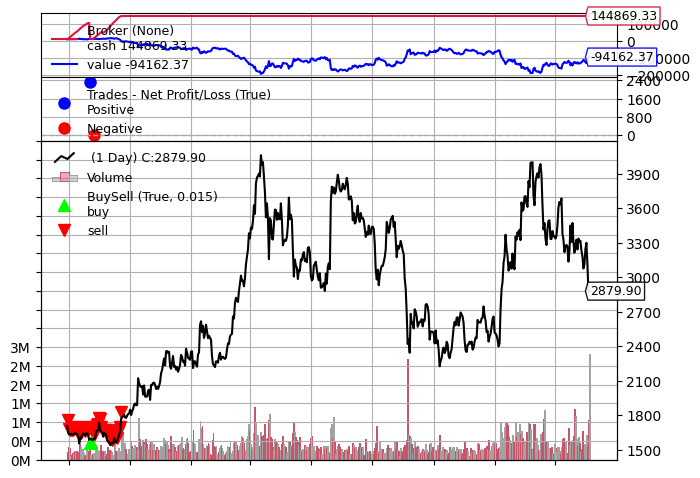

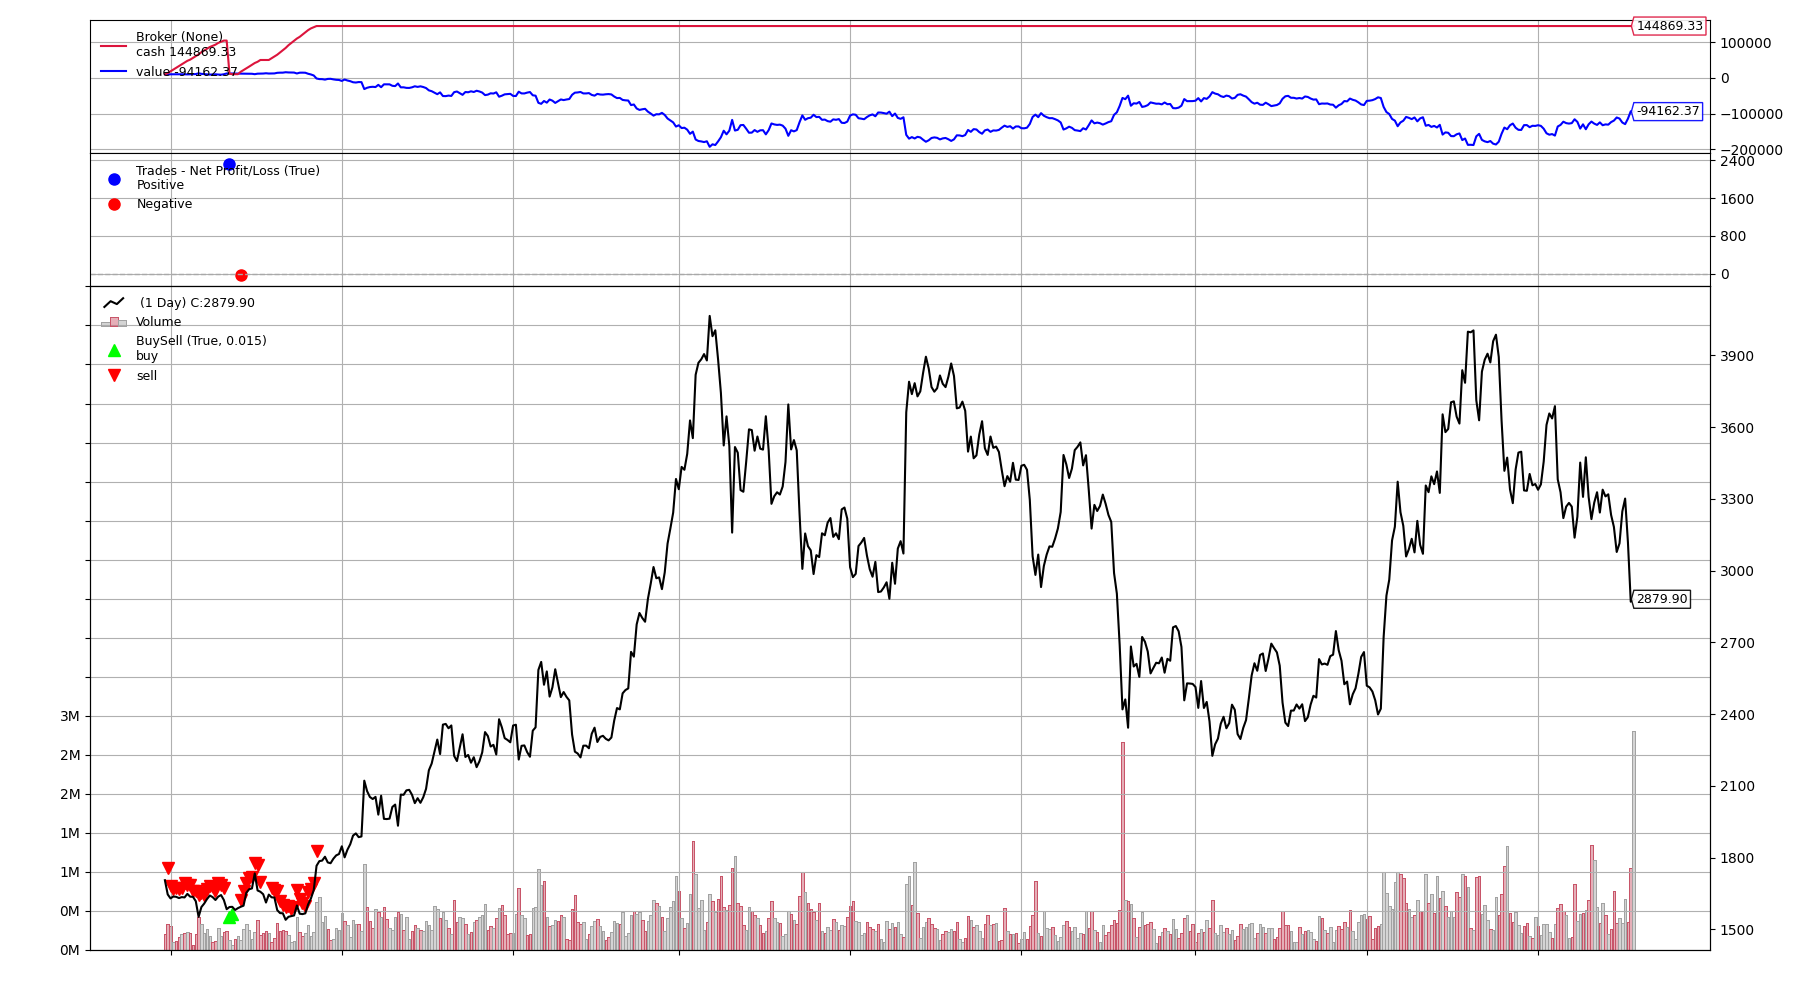

In [306]:
%matplotlib inline
figs = cerebro.plot(iplot=False, plotter=bt.plot.Plot(), figsize=(18, 10))
fig = figs[0][0]  # Get the matplotlib figure
fig.set_size_inches(18, 10)  # Optional in case it's ignored

fig.savefig('large_plot.png')
from IPython.display import Image
Image('large_plot.png')